# Multi-Sensor Synchronization for Maritime Perception

## Project goal

To synchronize multi-sensor data (LiDAR, W-Band Radar, X-Band Radar) based on GNSS timestamp and pose information, then use extrinsic calibration matrices to transform all sensor data into a common coordinate frame (e.g., GNSS/base frame) for fusion and analysis.

In [ ]:
!pip install open3d -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.7/447.7 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.5 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import json
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

In [ ]:
# --- Setup paths ---
DATA_DIR = Path("/content/drive/MyDrive")
CALIB_DIR = DATA_DIR / "calibration"
GNSS_FILE = DATA_DIR / "gnss.csv"

LIDAR_DIR = DATA_DIR / "lidar"
WBAND_DIR = DATA_DIR / "W_band_radar"
XBAND_DIR = DATA_DIR / "X_band_radar"
OUTPUT_DIR = DATA_DIR / "synced_output"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
# --- Helper: Load calibration matrices, skip label/header rows ---
def load_matrix(path):
    matrix = []
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            try:
                row = [float(x) for x in parts]
                if len(row) == 4:
                    matrix.append(row)
                else:
                    print(f"⚠️ Skipped line due to unexpected number of columns ({len(row)}): {line.strip()}")
            except ValueError:
                print(f"⚠️ Skipped non-numeric line: {line.strip()}")
                continue
    return np.array(matrix)


In [ ]:
# --- Load transformations ---
T_base2lidar = load_matrix(CALIB_DIR / "Base2lidar.txt")
T_base2xband = load_matrix(CALIB_DIR / "Base2xband.txt")

# --- Index files by timestamp ---
def index_files_by_timestamp(folder, ext):
    if not folder.exists():
        return {}
    return {int(f.stem): f for f in folder.glob(f"*.{ext}") if f.stem.isdigit()}

lidar_ts = index_files_by_timestamp(LIDAR_DIR, "bin")
xband_ts = index_files_by_timestamp(XBAND_DIR, "png")
wband_ts = index_files_by_timestamp(WBAND_DIR, "png")

print("✅ LiDAR timestamps:", sorted(lidar_ts.keys()))
print("✅ X-Band timestamps:", sorted(xband_ts.keys()))
print("✅ W-Band timestamps:", sorted(wband_ts.keys()))

⚠️ Skipped non-numeric line: Tr_gnss_to_lidar: 0 1 0 0
⚠️ Skipped non-numeric line: Tr_gnss_to_Xband: 0 1 0 0
✅ LiDAR timestamps: [1724625894214986733, 1724625895215083629, 1724625896214996143, 1724625897214523898, 1724625898214689771, 1724625899215104389, 1724625900214582820, 1724625901214440138, 1724625902214442464, 1724625903214564256, 1724625904214334628, 1724625905214665987, 1724625906214676569, 1724625907215025203, 1724625908215015260, 1724625909215616243, 1724625910215856565, 1724625911215887636, 1724625912214879989, 1724625913215255930, 1724625914214978437, 1724625915215265368, 1724625916215877261, 1724625917215420405, 1724625918215834758, 1724625919215939347, 1724625920215844439, 1724625921215385817, 1724625922215306315, 1724625923214700225]
✅ X-Band timestamps: [1724625894223082375, 1724625895223246991, 1724625896223124316, 1724625897222549275, 1724625898222744536, 1724625899223239997, 1724625900222863379, 1724625901222553601, 1724625902222586363, 1724625903222734625, 1724625

In [ ]:
# --- Match timestamps (LiDAR & X-Band only) ---
def find_closest(ts, candidates, tolerance_ns=1e7):  # 10 ms
    if not candidates:
        return None
    closest = min(candidates, key=lambda x: abs(x - ts))
    return closest if abs(closest - ts) <= tolerance_ns else None

aligned_ts = []
for ts_lidar in sorted(lidar_ts):
    ts_x = find_closest(ts_lidar, xband_ts.keys(), tolerance_ns=1e7)
    if ts_x is not None:
        aligned_ts.append((ts_lidar, ts_x))

print(f"✅ Matched timestamps: {len(aligned_ts)}")

✅ Matched timestamps: 30


In [ ]:
# --- Loaders ---
def load_lidar(file):
    pts = np.fromfile(file, dtype=np.float32).reshape(-1, 4)[:, :3]
    pts_h = np.hstack([pts, np.ones((pts.shape[0], 1))])
    pts_base = (T_base2lidar @ pts_h.T).T[:, :3]
    return pts_base

def load_image(file):
    img = Image.open(file).convert("L")
    return np.array(img)


In [ ]:
# --- Load GNSS ---
gnss_df = pd.read_csv(GNSS_FILE)
if 'timestamp' in gnss_df.columns:
    gnss_df['timestamp'] = pd.to_numeric(gnss_df['timestamp'], errors='coerce')
    gnss_df = gnss_df.dropna(subset=['timestamp'])

def get_gnss_for_ts(ts):
    if 'timestamp' not in gnss_df.columns:
        return None
    row = gnss_df.iloc[(gnss_df['timestamp'] - ts).abs().argsort()[:1]]
    return row.to_dict('records')[0] if not row.empty else None

In [ ]:
# --- Synchronize & Save ---
synced_data = []
summary_records = []

for i, (ts_lidar, ts_x) in enumerate(aligned_ts):
    try:
        lidar_data = load_lidar(lidar_ts[ts_lidar])
        xband_img = load_image(xband_ts[ts_x])
        gnss_info = get_gnss_for_ts(ts_lidar)

        # Save data
        np.save(OUTPUT_DIR / f"lidar_{i}.npy", lidar_data)
        Image.fromarray(xband_img).save(OUTPUT_DIR / f"xband_{i}.png")
        with open(OUTPUT_DIR / f"gnss_{i}.json", 'w') as f:
            json.dump(gnss_info, f)

        synced_data.append({
            "timestamp": ts_lidar,
            "lidar": lidar_data,
            "xband": xband_img,
            "gnss": gnss_info
        })

        summary_records.append({
            "index": i,
            "timestamp": ts_lidar,
            "lidar_shape": lidar_data.shape,
            "xband_shape": xband_img.shape,
            "gnss_lat": gnss_info.get("latitude") if gnss_info else None,
            "gnss_lon": gnss_info.get("longitude") if gnss_info else None
        })

    except Exception as e:
        print(f"⚠️ Skipping frame {i} at lidar ts {ts_lidar} due to: {e}")

In [ ]:
# --- Save Summary Metadata ---
if summary_records:
    pd.DataFrame(summary_records).to_csv(OUTPUT_DIR / "synced_summary.csv", index=False)
    print(f"\n✅ Synchronized {len(synced_data)} frames saved in: {OUTPUT_DIR}")
else:
    print("⚠️ No synchronized data saved.")


✅ Synchronized 30 frames saved in: /content/drive/MyDrive/synced_output



✅ Synchronized Frame Summary:
             timestamp lidar_shape   xband_shape  \
0  1724625894214986733  (32061, 2)  (2048, 2048)   

                                           gnss_info  
0  {'rosbag_file': 'S_HONESTMISTAKE_SEAD-CM-2200-...  


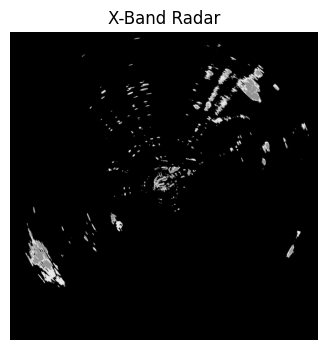

In [ ]:
# --- Show a Sample Frame ---
if synced_data:
    frame = synced_data[0]
    print("\n✅ Synchronized Frame Summary:")
    print(pd.DataFrame([{
        "timestamp": frame["timestamp"],
        "lidar_shape": frame["lidar"].shape,
        "xband_shape": frame["xband"].shape,
        "gnss_info": frame["gnss"]
    }]))

    plt.figure(figsize=(5, 4))
    plt.title("X-Band Radar")
    plt.imshow(frame['xband'], cmap='gray')
    plt.axis("off")
    plt.show()